# Tutorial 08: Benchmarking against batch BO methods
We will compare SOBER with all batch BO baseline on continuous Branin function.
- Thompson sampling [code from BoTorch](https://botorch.org/tutorials/thompson_sampling), [paper](https://proceedings.mlr.press/v84/kandasamy18a.html)
- Decoupled Thompson sampling [code from @saitcakmak](https://github.com/saitcakmak/gp-sampling), [paper](https://arxiv.org/abs/2002.09309)
- Determinantal Point Process (DPP) - Thompson sampling (code is provided by the author [@elvisnava](https://github.com/elvisnava/)), [paper](https://arxiv.org/abs/2110.11665)
- GIBBON [code from BoTorch](https://botorch.org/tutorials/GIBBON_for_efficient_batch_entropy_search). [paper](https://arxiv.org/abs/2102.03324)
- Hallucination [paper](https://papers.nips.cc/paper_files/paper/2010/hash/e702e51da2c0f5be4dd354bb3e295d37-Abstract.html)
- local penalisation [paper](https://proceedings.mlr.press/v51/gonzalez16a.html)
- TurBO [code from BoTorch](https://botorch.org/tutorials/turbo_1), [paper](https://arxiv.org/abs/1910.01739)
- SOBER-Thompson sampling

In [19]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import copy
import torch
import warnings
import matplotlib.pyplot as plt
from SOBER._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

### 1. Visualise the true function surface

In [20]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

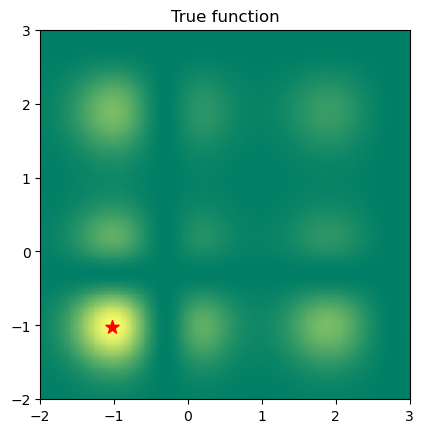

In [36]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

def get_plotting_domain():
    x = torch.linspace(lower_limit, upper_limit, resolution)
    y = torch.linspace(lower_limit, upper_limit, resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return tm.standardise_tensor(X_grid)

def plot_function(data, ax):
    data = tm.numpy(data).reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[lower_limit, upper_limit, lower_limit, upper_limit],
        interpolation='nearest',
        origin='lower',
    )
    ax.scatter(ground_truth[1], ground_truth[0], s=100, marker="*", color="red")

def plot_white(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=10, color="white")

def plot_black(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="+", color="black")

def plot(X_init, X_batch, title):
    fig, ax = plt.subplots()
    Xgrid = get_plotting_domain()
    Ygrid = BraninFunction(Xgrid)
    plot_function(Ygrid, ax)
    plot_white(X_init, ax)
    plot_black(X_batch, ax)
    plt.title(title)
    plt.show()
    
fig, ax = plt.subplots()
Xgrid = get_plotting_domain()
Ygrid = BraninFunction(Xgrid)
plot_function(Ygrid, ax)
plt.title("True function")
plt.show()

### 2. Modelling Gaussian Process with GPyTorch

In [32]:
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from SOBER._sober import Sober

def set_rbf_model(X, Y):
    """
    Set up the Gaussian process model with RBF kernel.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    base_kernel = RBFKernel()
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    if tm.is_cuda():
        return model.cuda()
    else:
        return model

def optimise_model(model):
    """
    Optimise the hyperparameters of Gaussian process model using L-BFGS-B (BoTorch optimizer)
    
    Args:
    - model: gpytorch.models, the optimised GP model.
    
    Return:
    - model: gpytorch.models, the optimised GP model.
    """
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

def set_model(X, Y):
    model = set_rbf_model(X, Y)
    return optimise_model(model)

def predict(test_x, model):
    model.eval()
    model.likelihood.eval()

    try:
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = model.likelihood(model(test_x))
    except:
        warnings.warn("Cholesky failed. Adding more jitter...")
        with torch.no_grad(), gpytorch.settings.cholesky_jitter(float=1e-2):
            pred = model.likelihood(model(test_x))
    return pred.mean, pred.variance

### 4. Set experimental conditions
For faster computation, we set small values for both number of candidates and batch size.<br>
When increasing these number, you will see how slow the compuations of existing algorithms are.

In [98]:
# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds)

# initial sampling
random_seed = 5    # random seed that determines random behaviours
torch.manual_seed(random_seed)

n_init = 10        # number of initial samples
Xinit = prior.sample(n_init)
Yinit = BraninFunction(Xinit)

# set experimental conditions
batch_size = 10    # number of batch samples
n_cand = 1000      # number of candidates sampled from pi
n_nys=200          # number of Nyström samples

### 4. Run comparisons

In [99]:
from benchmarks._batch_bo import (
    thompson_sampling,
    decoupled_thompson_sampling,
    DPP_TS,
    GIBBON,
    Hallucination,
    local_penalisation,
    TurboState,
    update_state,
    turbo,
    SOBER_TS,
)

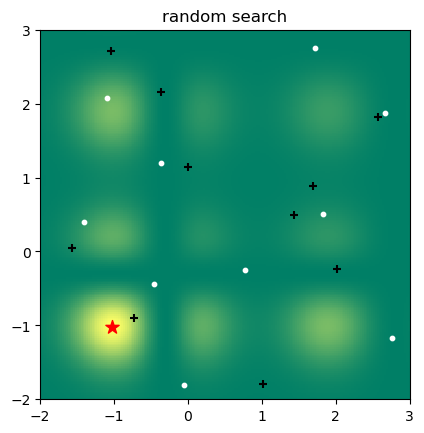

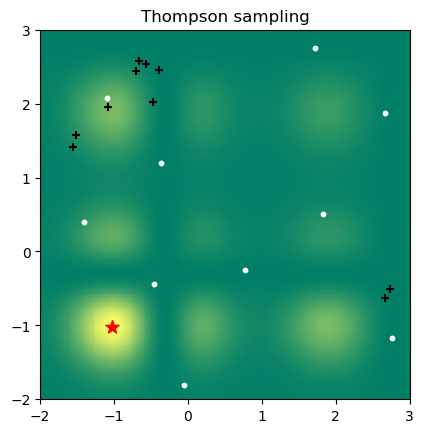

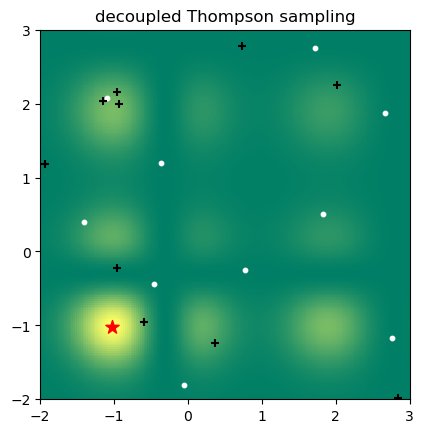

torch.Size([1000])


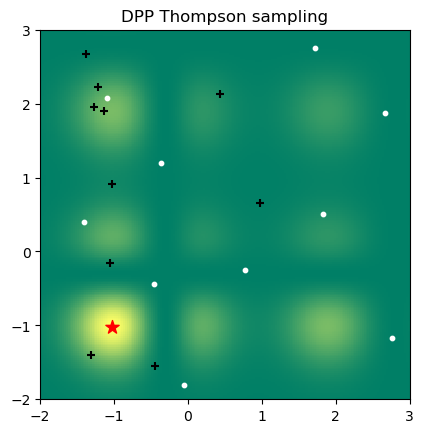

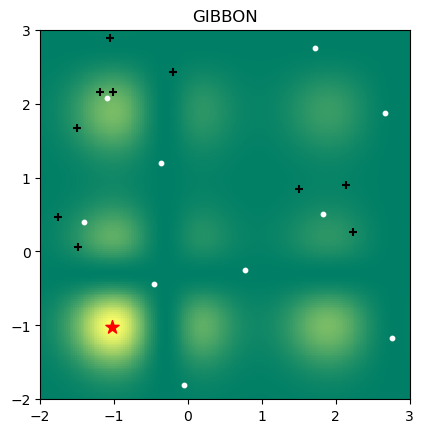

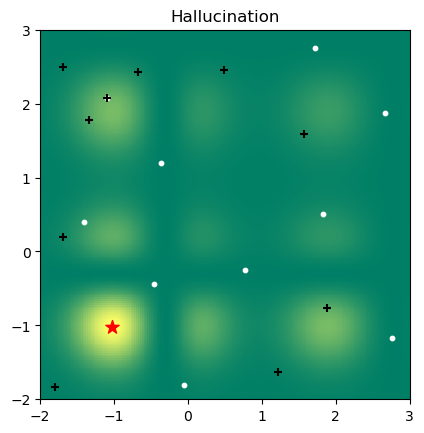

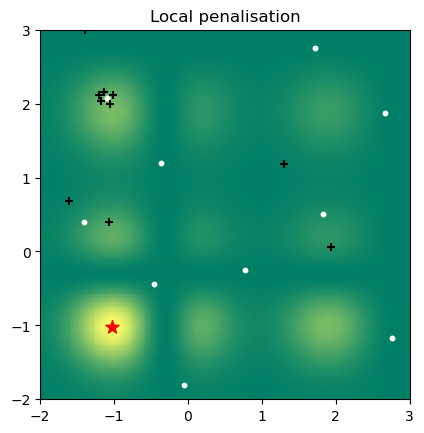

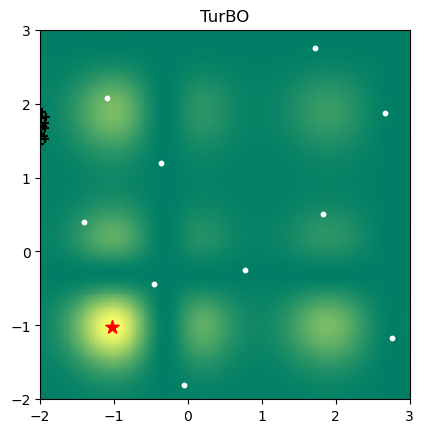

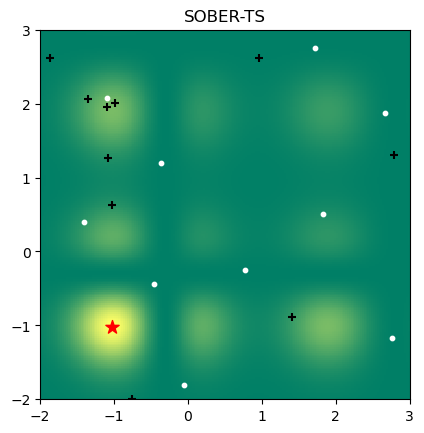

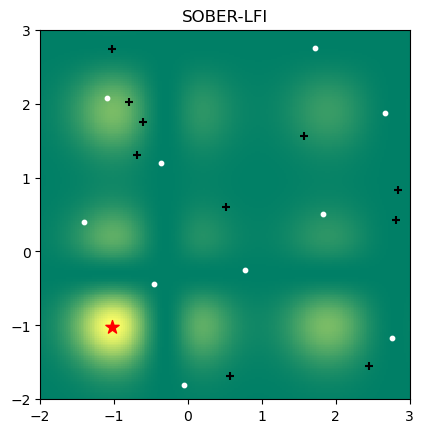

In [100]:
model = set_model(Xinit, Yinit) # train model on initial random data

X_batch_random = prior.sample(batch_size) # random search
plot(Xinit, X_batch_random, "random search")

X_batch_ts = thompson_sampling(model, prior, n_cand, batch_size)
plot(Xinit, X_batch_ts, "Thompson sampling")

X_batch_dts = decoupled_thompson_sampling(model, prior, n_cand, batch_size)
plot(Xinit, X_batch_dts, "decoupled Thompson sampling")

X_batch_dppts = DPP_TS(model, BraninFunction, prior, n_cand, batch_size)
plot(Xinit, X_batch_dppts, "DPP Thompson sampling")

X_batch_gibbon = GIBBON(model, prior, n_rec, batch_size)
plot(Xinit, X_batch_gibbon, "GIBBON")

X_batch_hal = Hallucination(model, set_model, prior, batch_size)
plot(Xinit, X_batch_hal, "Hallucination")

X_batch_lp = local_penalisation(model, prior, batch_size, LIPSCHITZ=10)
plot(Xinit, X_batch_lp, "Local penalisation")

state  = TurboState(dim=n_dims, batch_size=batch_size)
X_batch_turbo = turbo(state, model, prior, batch_size)
plot(Xinit, X_batch_turbo, "TurBO")

X_batch_soberts = SOBER_TS(model, prior, batch_size, n_cand_super=20000, n_cand=n_cand, n_nys=200)
plot(Xinit, X_batch_soberts, "SOBER-TS")

sober = Sober(prior, model)
X_batch_sober = sober.next_batch(n_cand, n_nys, batch_size)
plot(Xinit, X_batch_sober, "SOBER-LFI")

### 5. Compare the convergence

In [103]:
def calc_batch(Xall, Yall, state):
    X_batch_random = prior.sample(batch_size) # random search
    
    model = set_model(Xall[1], Yall[1])
    X_batch_ts = thompson_sampling(model, prior, n_cand, batch_size)
    model = set_model(Xall[2], Yall[2])
    X_batch_dts = decoupled_thompson_sampling(model, prior, n_cand, batch_size)
    model = set_model(Xall[3], Yall[3])
    X_batch_dppts = DPP_TS(model, BraninFunction, prior, n_cand, batch_size)
    model = set_model(Xall[4], Yall[4])
    X_batch_gibbon = GIBBON(model, prior, n_rec, batch_size)
    model = set_model(Xall[5], Yall[5])
    X_batch_hal = Hallucination(model, set_model, prior, batch_size)
    model = set_model(Xall[6], Yall[6])
    try:
        X_batch_lp = local_penalisation(model, prior, batch_size, LIPSCHITZ=1)
    except:
        X_batch_lp = local_penalisation(model, prior, batch_size, LIPSCHITZ=10)
    model = set_model(Xall[7], Yall[7])
    X_batch_turbo = turbo(state, model, prior, batch_size)
    model = set_model(Xall[8], Yall[8])
    X_batch_soberts = SOBER_TS(model, prior, batch_size, n_cand_super=20000, n_cand=2000, n_nys=200)
    model = set_model(Xall[9], Yall[9])
    sober = Sober(prior, model)
    X_batch_sober = sober.next_batch(n_rec=20000, n_nys=500, batch_size=10)
    X_next = [X_batch_random, X_batch_ts, X_batch_dts, X_batch_dppts, X_batch_gibbon, X_batch_hal, X_batch_lp, X_batch_turbo, X_batch_soberts, X_batch_sober]
    return X_next

def update(X_next, Xall, Yall, Ymaxall, state):
    Xalls, Yalls, Ymaxalls = [], [], []
    for X, _Xall, _Yall, Ymax in zip(X_next, Xall, Yall, Ymaxall):
        Y = BraninFunction(X)
        Xall_cat = torch.cat((_Xall, X), dim=0)
        Yall_cat = torch.cat((_Yall, Y), dim=0)
        Xalls.append(Xall_cat)
        Yalls.append(Yall_cat)
        Ymaxalls.append(torch.cat([Ymax, Yall_cat.max().unsqueeze(-1)]))
    state = update_state(state, Yalls[7])
    return Xalls, Yalls, Ymaxalls, state

In [104]:
n_iterations = 5

state  = TurboState(dim=n_dims, batch_size=batch_size)
Ymax = Yinit.max().unsqueeze(-1)
Xall = [Xinit, Xinit, Xinit, Xinit, Xinit, Xinit, Xinit, Xinit, Xinit, Xinit]
Yall = [Yinit, Yinit, Yinit, Yinit, Yinit, Yinit, Yinit, Yinit, Yinit, Yinit]
Ymaxes = [Ymax, Ymax, Ymax, Ymax, Ymax, Ymax, Ymax, Ymax, Ymax, Ymax]

for idx in range(n_iterations):
    X_next = calc_batch(Xall, Yall, state)
    Xall, Yall, Ymaxes, state = update(X_next, Xall, Yall, Ymaxes, state)

torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


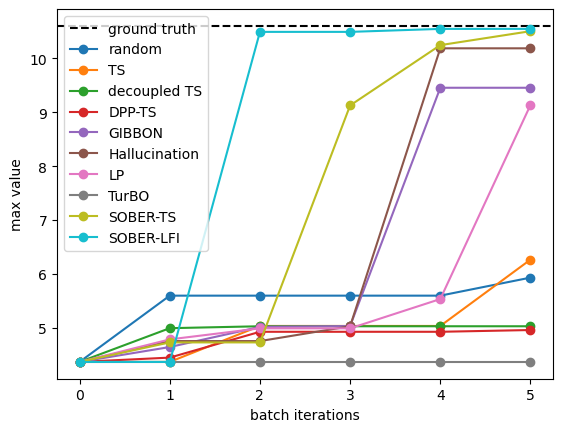

In [107]:
labels = ["random", "TS", "decoupled TS", "DPP-TS", "GIBBON", "Hallucination", "LP", "TurBO", "SOBER-TS", "SOBER-LFI"]

ytrue = 10.604333877563477
idx_batch = torch.arange(n_iterations+1)

plt.axhline(y=ytrue, linestyle="--", color="k", label="ground truth")
for idx, Ymax in enumerate(Ymaxes):
    plt.plot(idx_batch, Ymax, 'o-', label=labels[idx])
    plt.legend()
    plt.ylabel("max value")
    plt.xlabel("batch iterations")